<a href="https://colab.research.google.com/github/RavinduP/Product_Success/blob/Market_demand_forecasting/phophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Import r2_score
import numpy as np

In [2]:
# Load the dataset (adjust the file path in Colab as needed)
file_path = '/content/Ladders updated data.xlsx'
data = pd.ExcelFile(file_path)

# Load the 'Data' sheet
df = data.parse('Data')

# Display the first few rows to understand the structure
print(df.head())

  Billing Date  Net Weight Sales Region  Invoice Value      Material Code  \
0   2023-02-08    0.010106           EX          71.50  FAML0504N000N2000   
1   2022-09-22    0.005570           R2       10732.17  FASL3000M001L0700   
2   2022-09-22    0.004850           R2        9202.18  FASL3000M001L0600   
3   2022-09-22    0.007850           R2       15373.92  FASL2000M001N0800   
4   2022-10-16    0.004850           R2        9202.18  FASL3000M001L0600   

                   Size  QTY(EA)  
0  Multy Purpose Ladder        1  
1           STEP LADDER        1  
2           STEP LADDER        1  
3           STEP LADDER        1  
4           STEP LADDER        1  


In [3]:
# Convert Billing Date to datetime
df['Billing Date'] = pd.to_datetime(df['Billing Date'])

# Extract year, month, day, and weekday
df['Year'] = df['Billing Date'].dt.year
df['Month'] = df['Billing Date'].dt.month
df['Day'] = df['Billing Date'].dt.day
df['Weekday'] = df['Billing Date'].dt.weekday  # 0=Monday, 6=Sunday

print(df[['Billing Date', 'Year', 'Month', 'Day', 'Weekday']].head())

  Billing Date  Year  Month  Day  Weekday
0   2023-02-08  2023      2    8        2
1   2022-09-22  2022      9   22        3
2   2022-09-22  2022      9   22        3
3   2022-09-22  2022      9   22        3
4   2022-10-16  2022     10   16        6


In [4]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values (example for QTY(EA))
df['QTY(EA)'].fillna(df['QTY(EA)'].median(), inplace=True)


Billing Date     0
Net Weight       0
Sales Region     0
Invoice Value    0
Material Code    0
Size             0
QTY(EA)          0
Year             0
Month            0
Day              0
Weekday          0
dtype: int64


<ipython-input-4-8a442ea6c2a9>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['QTY(EA)'].fillna(df['QTY(EA)'].median(), inplace=True)


In [5]:
# Create lag features for past 1, 2, and 3 months
df['Lag_1'] = df['QTY(EA)'].shift(1)
df['Lag_2'] = df['QTY(EA)'].shift(2)
df['Lag_3'] = df['QTY(EA)'].shift(3)
df['Lag_6'] = df['QTY(EA)'].shift(6)
df['Lag_12'] = df['QTY(EA)'].shift(12)  # Yearly seasonality


In [6]:
# Rolling mean and standard deviation
df['Rolling_Mean_3'] = df['QTY(EA)'].rolling(window=3).mean()
df['Rolling_Std_3'] = df['QTY(EA)'].rolling(window=3).std()


In [7]:
df['Is_Holiday_Season'] = df['Month'].isin([11, 12]).astype(int)  # Example: Holiday season = Nov-Dec


In [8]:
# Encode Sales Region using Label Encoding
df['Sales Region Encoded'] = df['Sales Region'].astype('category').cat.codes
print(df[['Sales Region', 'Sales Region Encoded']].head())


  Sales Region  Sales Region Encoded
0           EX                     1
1           R2                     5
2           R2                     5
3           R2                     5
4           R2                     5


In [9]:
# Region-wise sales growth
# Replace 'Billing Month' with the actual column name containing billing month information
# Assuming 'Month' column contains the billing month information
region_monthly = df.groupby(['Sales Region', 'Month'])['QTY(EA)'].sum().reset_index()
region_monthly['Sales Growth'] = region_monthly.groupby('Sales Region')['QTY(EA)'].pct_change()

In [10]:
# Aggregate monthly sales before calling adfuller
monthly_sales = df.groupby([df['Billing Date'].dt.to_period('M')])['QTY(EA)'].sum()
monthly_sales = monthly_sales.reset_index()
monthly_sales['Billing Date'] = monthly_sales['Billing Date'].dt.to_timestamp()

# Now you can perform the ADF test
result = adfuller(monthly_sales['QTY(EA)'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.8121994322765504
p-value: 0.3744220551339152


In [11]:
# One-hot encode the 'Size' column
size_encoded = pd.get_dummies(df['Size'], prefix='Size')

# Add one-hot encoded columns to the dataframe
df = pd.concat([df, size_encoded], axis=1)

# Encode Material Code with Label Encoding
df['Material Code Encoded'] = df['Material Code'].astype('category').cat.codes

print(df[['Size', 'Material Code', 'Material Code Encoded']].head())


                   Size      Material Code  Material Code Encoded
0  Multy Purpose Ladder  FAML0504N000N2000                      3
1           STEP LADDER  FASL3000M001L0700                     17
2           STEP LADDER  FASL3000M001L0600                     16
3           STEP LADDER  FASL2000M001N0800                      7
4           STEP LADDER  FASL3000M001L0600                     16


In [12]:
# Calculate Invoice Value per ladder
df['Value Per Unit'] = df['Invoice Value'] / df['QTY(EA)']

print(df[['Invoice Value', 'QTY(EA)', 'Value Per Unit']].head())


   Invoice Value  QTY(EA)  Value Per Unit
0          71.50        1           71.50
1       10732.17        1        10732.17
2        9202.18        1         9202.18
3       15373.92        1        15373.92
4        9202.18        1         9202.18


In [13]:
# Aggregate monthly sales
monthly_sales = df.groupby([df['Billing Date'].dt.to_period('M')])['QTY(EA)'].sum()
monthly_sales = monthly_sales.reset_index()
monthly_sales['Billing Date'] = monthly_sales['Billing Date'].dt.to_timestamp()

print(monthly_sales.head())

print(monthly_sales.tail())


  Billing Date  QTY(EA)
0   2022-04-01      623
1   2022-05-01      997
2   2022-06-01     1690
3   2022-07-01      544
4   2022-08-01      186
   Billing Date  QTY(EA)
26   2024-06-01      854
27   2024-07-01     1301
28   2024-08-01     1474
29   2024-09-01     1072
30   2024-10-01     1092


In [14]:
# Aggregate monthly sales
monthly_sales = df.groupby([df['Billing Date'].dt.to_period('M')])['QTY(EA)'].sum()
monthly_sales = monthly_sales.reset_index()
monthly_sales['Billing Date'] = monthly_sales['Billing Date'].dt.to_timestamp()

print(monthly_sales.head())

print(monthly_sales.tail())


  Billing Date  QTY(EA)
0   2022-04-01      623
1   2022-05-01      997
2   2022-06-01     1690
3   2022-07-01      544
4   2022-08-01      186
   Billing Date  QTY(EA)
26   2024-06-01      854
27   2024-07-01     1301
28   2024-08-01     1474
29   2024-09-01     1072
30   2024-10-01     1092


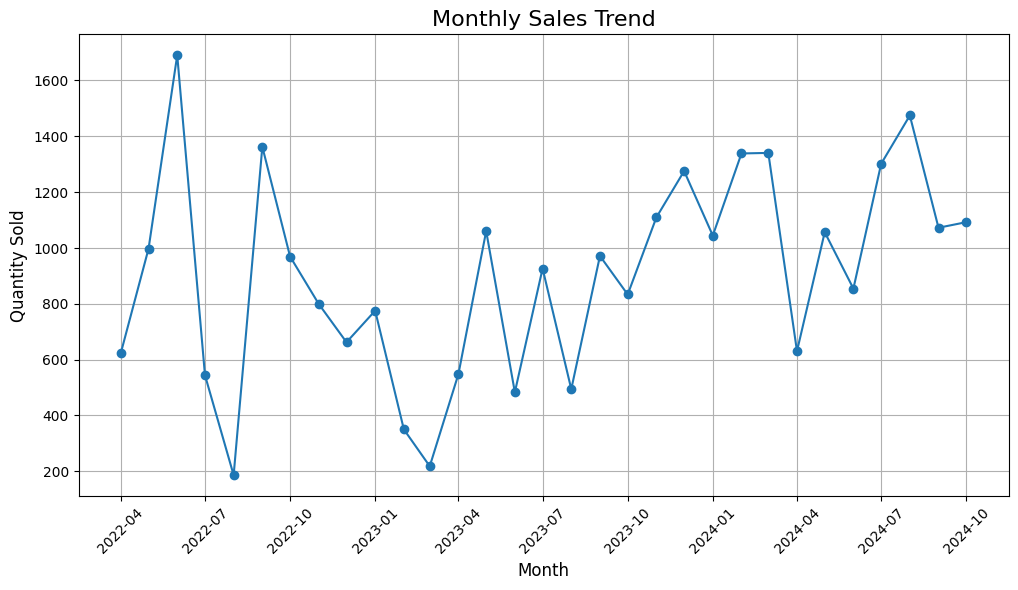

In [15]:
# Step 1: Analyze Sales Over Time
# Aggregate data by month and sum up quantities sold
df['Billing Month'] = df['Billing Date'].dt.to_period('M')
monthly_sales = df.groupby('Billing Month')['QTY(EA)'].sum().reset_index()
monthly_sales['Billing Month'] = monthly_sales['Billing Month'].dt.to_timestamp()

# Step 2: Visualize Monthly Sales Trends
plt.figure(figsize=(12, 6))
# Changed 'Billing Date' to 'Billing Month' as it's the column available after aggregation
plt.plot(monthly_sales['Billing Month'], monthly_sales['QTY(EA)'], marker='o', linestyle='-')
plt.title('Monthly Sales Trend', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [16]:
pip install prophet

In [17]:
from prophet import Prophet

# Prepare the data for Prophet
prophet_data = monthly_sales.rename(columns={'Billing Month': 'ds', 'QTY(EA)': 'y'})

# Display the first few rows
print(prophet_data.head())

          ds     y
0 2022-04-01   623
1 2022-05-01   997
2 2022-06-01  1690
3 2022-07-01   544
4 2022-08-01   186


In [18]:
# Initialize the Prophet model
model = Prophet()

# Fit the model on the data
model.fit(prophet_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5c2uvusv/lox1r5qt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5c2uvusv/dgn6q71a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2393', 'data', 'file=/tmp/tmp5c2uvusv/lox1r5qt.json', 'init=/tmp/tmp5c2uvusv/dgn6q71a.json', 'output', 'file=/tmp/tmp5c2uvusv/prophet_modelxy_tp6ai/prophet_model-20250202064134.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:41:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:41:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

In [19]:
# Create a dataframe to hold predictions
future = model.make_future_dataframe(periods=12, freq='M')

# Predict the future values
forecast = model.predict(future)

# Display the forecasted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

           ds         yhat   yhat_lower   yhat_upper
38 2025-05-31  1569.146709  1247.383237  1885.903963
39 2025-06-30  1115.273322   794.301041  1427.964085
40 2025-07-31   224.700310  -100.808689   554.899679
41 2025-08-31  1794.102484  1465.315362  2125.651162
42 2025-09-30  1249.676371   924.512071  1559.627789


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


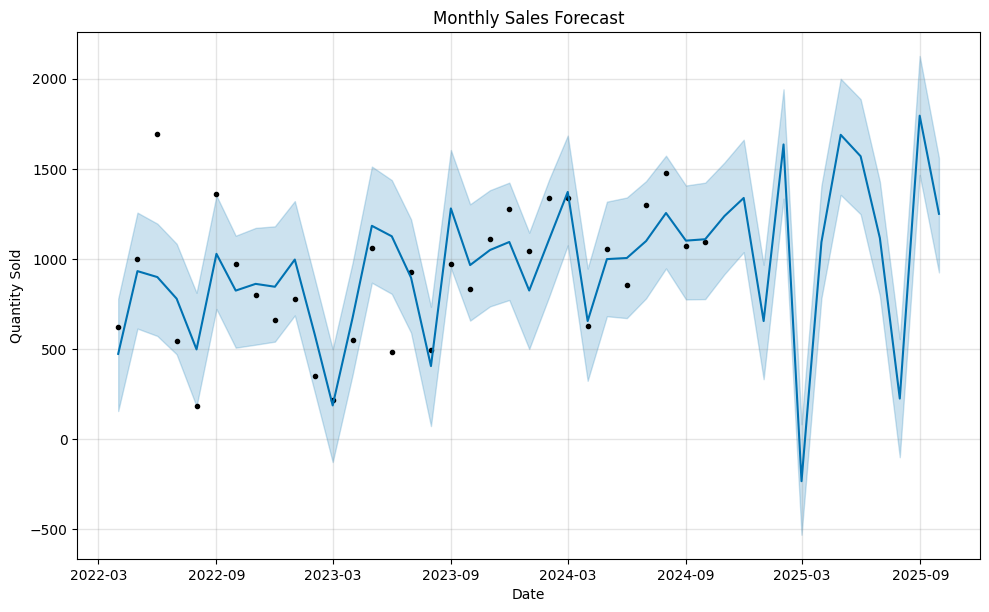

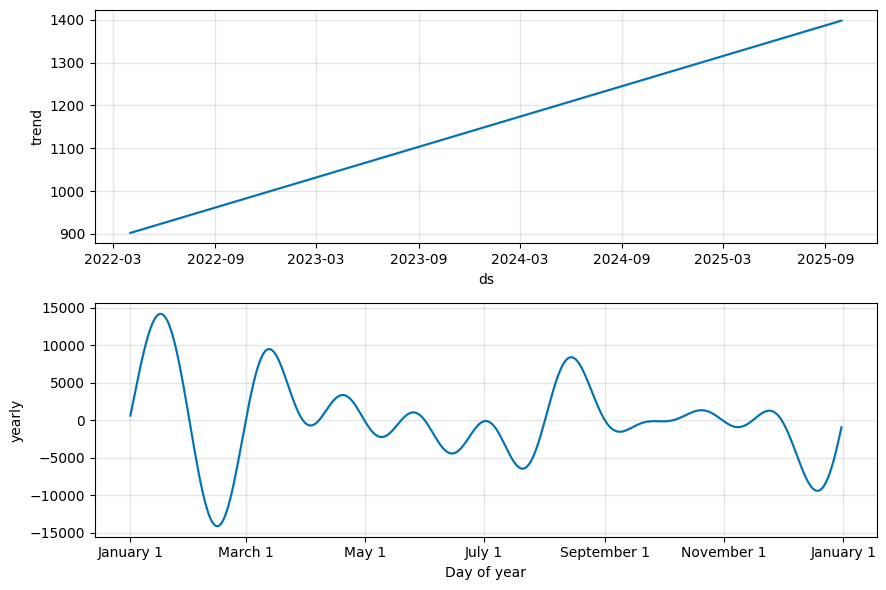

In [20]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Monthly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Merge the actual and predicted values
performance = pd.merge(prophet_data, forecast[['ds', 'yhat']], on='ds')

# Calculate evaluation metrics
mae = mean_absolute_error(performance['y'], performance['yhat'])
mse = mean_squared_error(performance['y'], performance['yhat'])
r2 = r2_score(performance['y'], performance['yhat'])

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R-squared: {r2}')

MAE: 181.81138923778775
MSE: 61268.08318443064
R-squared: 0.5433338644147292


ds    0
y     0
dtype: int64
ds    datetime64[ns]
y              int64
dtype: object


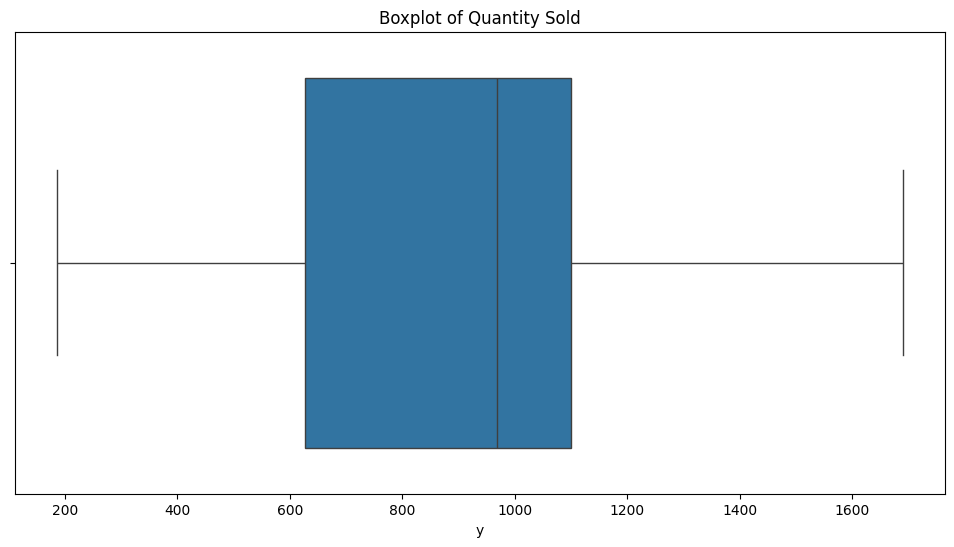

In [22]:
# Check for missing values
print(prophet_data.isnull().sum())

# Check data types
print(prophet_data.dtypes)

# Check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=prophet_data['y'])
plt.title('Boxplot of Quantity Sold')
plt.show()

In [23]:
from sklearn.model_selection import ParameterGrid
import numpy as np

# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Create all combinations of parameters
params = list(ParameterGrid(param_grid))

# Initialize a list to store results
results = []

# Perform grid search
for param in params:
    # Initialize the model with current parameters
    model = Prophet(
        changepoint_prior_scale=param['changepoint_prior_scale'],
        seasonality_prior_scale=param['seasonality_prior_scale'],
        seasonality_mode=param['seasonality_mode']
    )

    # Fit the model
    model.fit(prophet_data)

    # Make predictions
    future = model.make_future_dataframe(periods=12, freq='M')
    forecast = model.predict(future)

    # Merge actual and predicted values
    performance = pd.merge(prophet_data, forecast[['ds', 'yhat']], on='ds')

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(performance['y'], performance['yhat']))

    # Store results
    results.append({
        'params': param,
        'rmse': rmse
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort by RMSE to find the best parameters
results_df = results_df.sort_values(by='rmse').reset_index(drop=True)

# Display the best parameters
print("Best Parameters:")
print(results_df.iloc[0]['params'])
print(f"Best RMSE: {results_df.iloc[0]['rmse']}")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5c2uvusv/65gkb958.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5c2uvusv/8qljgeos.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43573', 'data', 'file=/tmp/tmp5c2uvusv/65gkb958.json', 'init=/tmp/tmp5c2uvusv/8qljgeos.json', 'output', 'file=/tmp/tmp5c2uvusv/prophet_modelipezhrpy/prophet_model-20250202064136.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Best Parameters:
{'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}
Best RMSE: 199.69149142779943


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [24]:
# Best parameters from grid search
best_params = results_df.iloc[0]['params']

# Initialize the model with the best parameters
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

# Fit the model
final_model.fit(prophet_data)

# Make predictions
future = final_model.make_future_dataframe(periods=12, freq='M')
forecast = final_model.predict(future)

# Merge actual and predicted values
performance = pd.merge(prophet_data, forecast[['ds', 'yhat']], on='ds')

# Calculate RMSE, MAE, and R-squared
rmse = np.sqrt(mean_squared_error(performance['y'], performance['yhat']))
mae = mean_absolute_error(performance['y'], performance['yhat'])
r2 = r2_score(performance['y'], performance['yhat'])

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5c2uvusv/vdg4iqcc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5c2uvusv/os9rymby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19126', 'data', 'file=/tmp/tmp5c2uvusv/vdg4iqcc.json', 'init=/tmp/tmp5c2uvusv/os9rymby.json', 'output', 'file=/tmp/tmp5c2uvusv/prophet_model0k7mhcf3/prophet_model-20250202064203.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:42:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:42:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:

RMSE: 199.69149142779943
MAE: 156.072243391635
R-squared: 0.7027761637985648


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


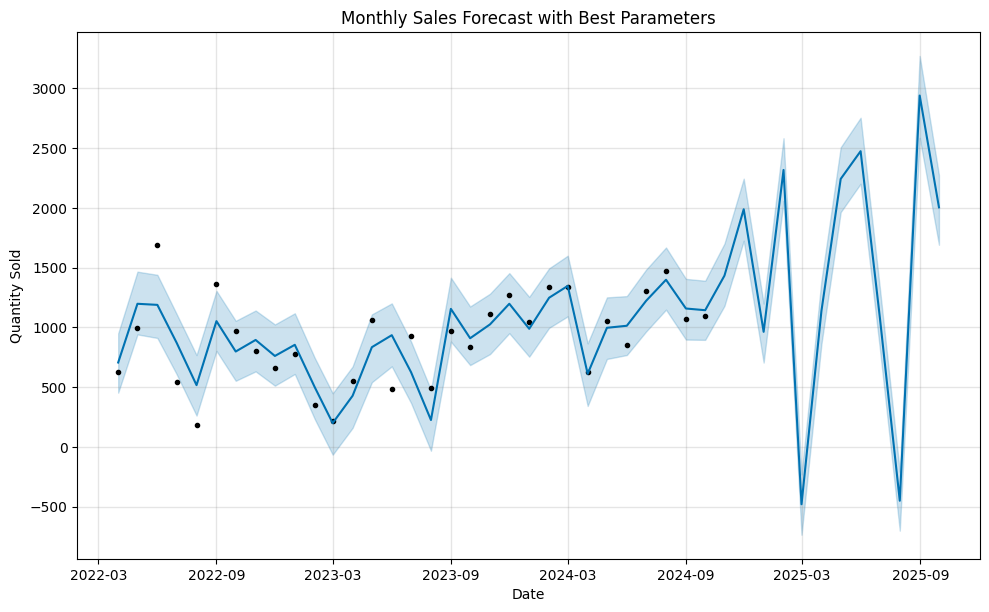

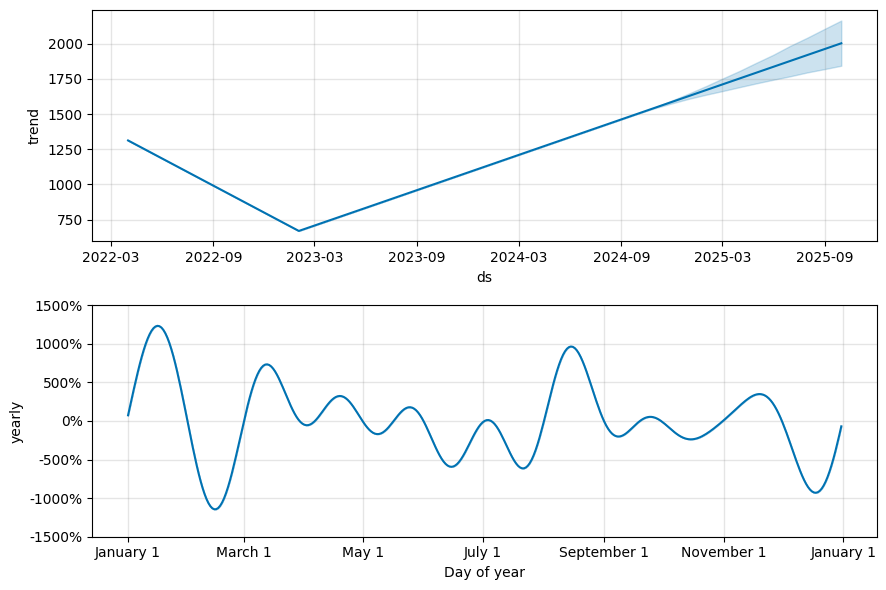

In [25]:
# Plot the forecast
fig1 = final_model.plot(forecast)
plt.title('Monthly Sales Forecast with Best Parameters')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.show()

# Plot the forecast components
fig2 = final_model.plot_components(forecast)
plt.show()

INFO:prophet:Making 3 forecasts with cutoffs between 2023-07-09 00:00:00 and 2024-07-03 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5c2uvusv/mflor8lp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5c2uvusv/8dqk9n6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57890', 'data', 'file=/tmp/tmp5c2uvusv/mflor8lp.json', 'init=/tmp/tmp5c2uvusv/8dqk9n6v.json', 'output', 'file=/tmp/tmp5c2uvusv/prophet_modelxkwrncyk/prophet_model-20250202064206.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:42:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:42:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5c2uvusv/_jud0x7l.json
DEBUG:cmdstanpy:input tempfi

  horizon           mse         rmse          mae      mape     mdape  \
0 23 days  9.266401e+04   304.407632   304.407632  0.616210  0.616210   
1 27 days  8.369757e+05   914.863749   914.863749  0.683755  0.683755   
2 29 days  3.813852e+06  1952.908641  1952.908641  1.324904  1.324904   
3 54 days  1.139341e+06  1067.399399  1067.399399  1.099278  1.099278   
4 56 days  4.434742e+05   665.938623   665.938623  0.496969  0.496969   

      smape  coverage  
0  0.890612       0.0  
1  1.038947       0.0  
2  2.000000       0.0  
3  0.709377       0.0  
4  0.661289       0.0  


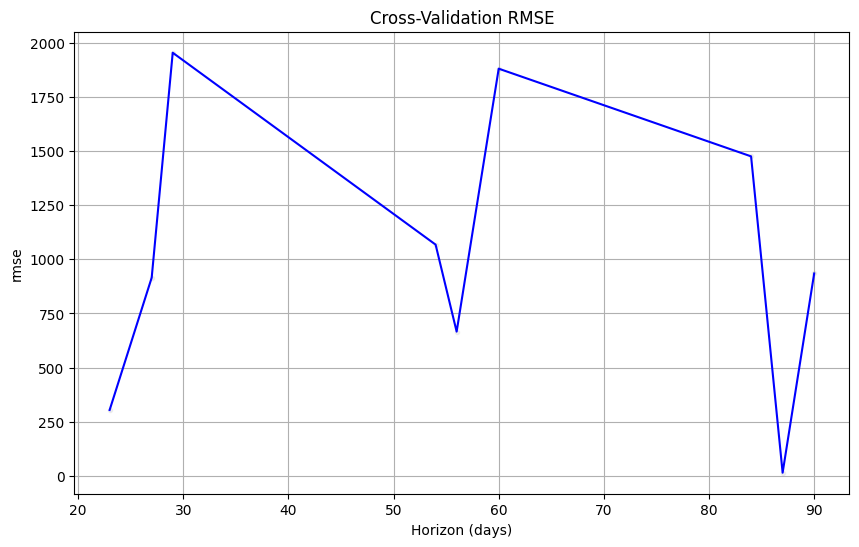

In [26]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
df_cv = cross_validation(final_model, initial='365 days', period='180 days', horizon='90 days')

# Calculate performance metrics
df_p = performance_metrics(df_cv)

# Display the metrics
print(df_p.head())

# Plot the cross-validation metrics
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.title('Cross-Validation RMSE')
plt.show()

In [27]:
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')

RMSE: 199.69149142779943
MAE: 156.072243391635
R-squared: 0.7027761637985648
